In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [308]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [309]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [310]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates


In [311]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [312]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [313]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [314]:
EHS_Q

,DATE,Existing Home Sales,House_Stock
0,1999Q1,5.160000,79655.0
1,1999Q2,5.233333,80146.0
2,1999Q3,5.200000,80656.0
3,1999Q4,5.093333,80094.0
4,2000Q1,5.180000,80776.0
...,...,...,...
88,2021Q1,6.286667,94048.0
89,2021Q2,5.950000,94117.0
90,2021Q3,6.066667,94192.0
91,2021Q4,6.203333,94865.0


In [315]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [323]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover
HPI_PO["YoY_MA"] = HPI_PO.YoY.rolling(5).mean()

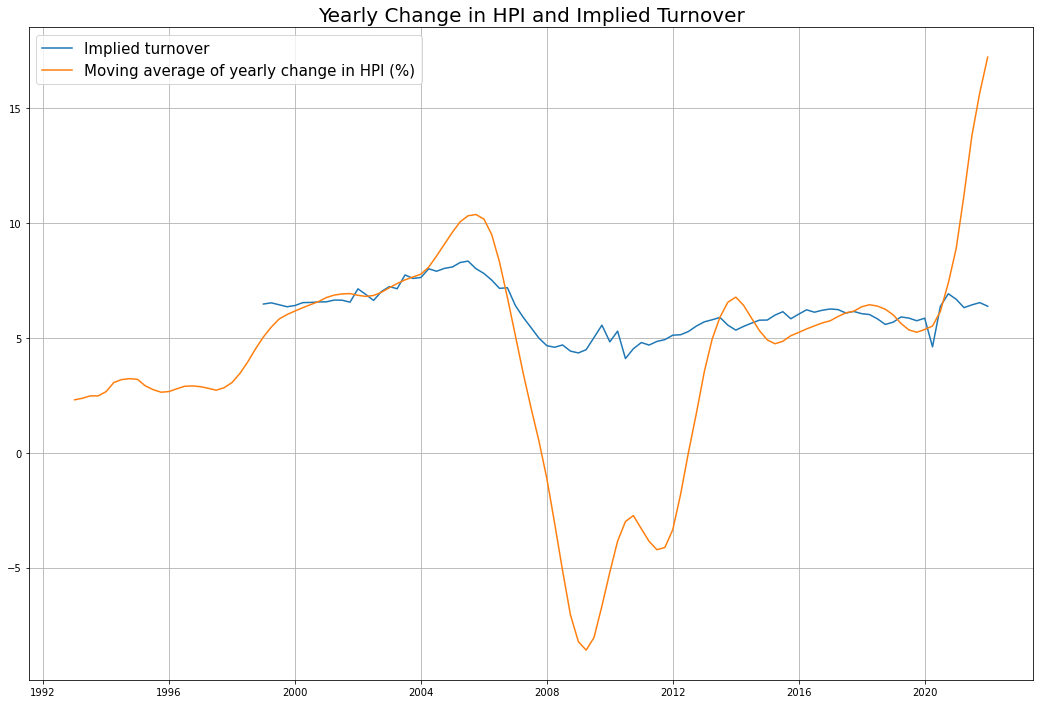

In [324]:
plt.figure(figsize=(18,12))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover.values, label = "Implied turnover")
plt.plot(HPI_PO.DATE, HPI_PO.YoY_MA, label = "Moving average of yearly change in HPI (%)")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Yearly Change in HPI and Implied Turnover", size = 20);


In [376]:
HCAI = pd.read_excel("HCAI.xlsx", sheet_name="Whole Market")
HCAI
new_header = HCAI.loc[2]
HCAI = HCAI[3:]
HCAI.columns = new_header
HCAI = HCAI[HCAI.columns[:6]]
HCAI.rename(columns={"Year" : "DATE"}, inplace=True)

In [377]:
HCAI.DATE = HCAI.DATE.apply(lambda x: str(x).split()[0])
DATE = HCAI.DATE.values
Quarter = HCAI.Quarter.values
new_dates = []
for i in range(len(DATE)):
    if Quarter[i] == 1:
        new_dates.append(DATE[i]+"-01-01")
    elif Quarter[i] == 2:
        new_dates.append(DATE[i]+"-04-01")
    elif Quarter[i] == 3:
        new_dates.append(DATE[i]+"-07-01")
    elif Quarter[i] == 4:
        new_dates.append(DATE[i]+"-10-01")
    else:
        raise ValueError("Invalid value for quarter")
HCAI.DATE = new_dates
HCAI.DATE = pd.to_datetime(HCAI.DATE)
HCAI.drop(columns=["Quarter", "highlight"], inplace=True)
HCAI.head(20)

2,DATE,Total\nRisk,Borrower\nRisk,Product\nRisk
3,1998-01-01,.,.,.
4,1998-04-01,.,.,.
5,1998-07-01,.,.,.
6,1998-10-01,.,.,.
7,1999-01-01,11.23586,8.836208,2.399652
8,1999-04-01,11.789989,9.040066,2.749923
9,1999-07-01,13.208564,9.471404,3.737161
10,1999-10-01,14.332389,10.160499,4.17189
11,2000-01-01,14.764346,10.371599,4.392747
12,2000-04-01,14.153728,9.89627,4.257458


In [384]:
HCAI.rename({"Total\nRisk" : "TotalRisk"}, inplace= True)
HCAI["Total\nRisk"].values

array(['.', '.', '.', '.', 11.235859827293538, 11.78998886611775,
       13.208564499893244, 14.33238880066361, 14.764346021396918,
       14.153728322282234, 13.52438144269722, 13.41171526722195,
       12.965604412878196, 12.510706889683672, 12.27171753703982,
       12.119570911435481, 12.210572305740236, 12.334477037283381,
       12.162916144796645, 12.01380419504772, 12.258474373120892,
       12.203949158255258, 12.130866767611277, 13.444420226531344,
       14.270052108806796, 14.39028052815716, 15.571829990816498,
       15.51591506186876, 15.671713738342017, 15.849004290267764,
       15.562967523487444, 16.370266561718623, 16.943254601565357,
       16.71093855068746, 16.734613648598447, 16.86281142540702,
       14.849225221913262, 10.99250393928708, 10.044011833407735,
       9.820999423723112, 8.124632662306947, 6.254727317935976,
       6.171907731700466, 6.5768086923428815, 6.6869268099359305,
       6.52449075823621, 6.748740872044445, 7.218978585036305,
       7.38587

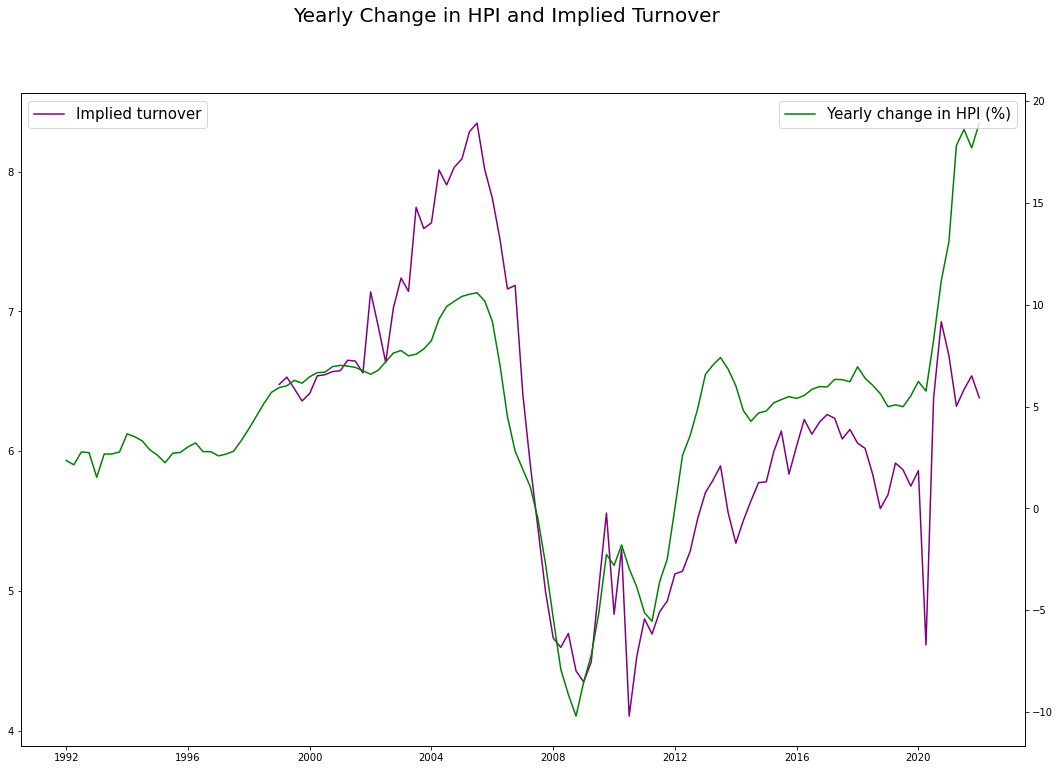

In [438]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(HPI_PO.DATE, HPI_PO.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'purple')
ax2 = ax1.twinx()
ax2.plot(HPI_PO.DATE, HPI_PO.YoY, linewidth=1.5,color='green',label='Yearly change in HPI (%)')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("Yearly Change in HPI and Implied Turnover", size = 20)
plt.show()
fig.savefig("HPIvsIT.png")